In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import gdown
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import rasterstats
from pprint import pprint
from osgeo import gdal

# import geoprofile
import micro
import gtsa

## Download sample data

In [3]:
# url = 'https://drive.google.com/drive/u/1/folders/1E1FbgeS2YHqnZOsXpbXTIpWhWT1oDR5N'
k13_dem_folder='../data/dems/k13_coreg/'
# # gdown.download_folder(url, output=k13_dem_folder, quiet=False, use_cookies=False)

# url = 'https://drive.google.com/drive/u/1/folders/1NBJ87RWqVEixA7XuN4uvmtjGJ03JIU56'
m14_dem_folder='../data/dems/m14_coreg/'
# gdown.download_folder(url, output=m14_dem_folder, quiet=False, use_cookies=False)

In [4]:
k13_wsyr1_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/wsyr1/*.tif'))
k13_wsyr1_dem_files = [i.as_posix() for i in k13_wsyr1_dem_files]

k13_dsyr1_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/dsyr1/*.tif'))
k13_dsyr1_dem_files = [i.as_posix() for i in k13_dsyr1_dem_files]

k13_wsyr2_dem_files = sorted(Path(k13_dem_folder).glob('KID-13/wsyr2/*.tif'))
k13_wsyr2_dem_files = [i.as_posix() for i in k13_wsyr2_dem_files]

m14_wsyr1_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/wsyr1/*.tif'))
m14_wsyr1_dem_files = [i.as_posix() for i in m14_wsyr1_dem_files]

m14_dsyr1_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/dsyr1/*.tif'))
m14_dsyr1_dem_files = [i.as_posix() for i in m14_dsyr1_dem_files]

m14_wsyr2_dem_files = sorted(Path(m14_dem_folder).glob('MEL-14/wsyr2/*.tif'))
m14_wsyr2_dem_files = [i.as_posix() for i in m14_wsyr2_dem_files]

In [5]:
k13_ortho1 = '/home/adalvis/github/micro_diff/data/orthomosaics/k13/k13_20201109_ortho.tif'
m14_ortho1 = '/home/adalvis/github/micro_diff/data/orthomosaics/m14/m14_20201203_ortho.tif'

## Select analysis ready data
- Assuming SfM and lidar collected on the same date are only used for validation of the SfM data
- Assuming the lidar is always "better" and will thus be used for the quantitative measurements and time series analysis

In [6]:
# KID-13
dsm_files_k13_wsyr1 = k13_wsyr1_dem_files
dsm_files_k13_dsyr1 = k13_dsyr1_dem_files
dsm_files_k13_wsyr2 = k13_wsyr2_dem_files

# MEL-14
dsm_files_m14_wsyr1 = m14_wsyr1_dem_files
dsm_files_m14_dsyr1 = m14_dsyr1_dem_files
dsm_files_m14_wsyr2 = m14_wsyr2_dem_files

## Parse time stamps

#### KID-13 WSYR1

In [7]:
strings_k13_wsyr1 = gtsa.io.parse_timestamps(dsm_files_k13_wsyr1, date_string_pattern='_........_')
date_strings_k13_wsyr1 = [x[1:-1] for x in strings_k13_wsyr1]

# ensure chronological sorting
date_strings_k13_wsyr1, dsm_files_k13_wsyr1 = list(zip(*sorted(zip(date_strings_k13_wsyr1, dsm_files_k13_wsyr1))))
date_times_k13_wsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_k13_wsyr1]

list(zip(date_strings_k13_wsyr1, dsm_files_k13_wsyr1))

[('20201109',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20201109_lidar_coreg.tif'),
 ('20201110',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20201110_sfm_coreg.tif'),
 ('20210208',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210208_sfm_coreg.tif'),
 ('20210208',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210208_sfm_coreg_1.tif'),
 ('20210406',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210406_sfm_coreg.tif'),
 ('20210406',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210406_sfm_coreg_1.tif'),
 ('20210513',
  '../data/dems/k13_coreg/KID-13/wsyr1/k13_20210513_sfm_coreg.tif')]

#### KID-13 DSYR1

In [8]:
strings_k13_dsyr1 = gtsa.io.parse_timestamps(dsm_files_k13_dsyr1, date_string_pattern='_........_')
date_strings_k13_dsyr1 = [x[1:-1] for x in strings_k13_dsyr1]

# ensure chronological sorting
date_strings_k13_dsyr1, dsm_files_k13_dsyr1 = list(zip(*sorted(zip(date_strings_k13_dsyr1, dsm_files_k13_dsyr1))))
date_times_k13_dsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_k13_dsyr1]

list(zip(date_strings_k13_dsyr1, dsm_files_k13_dsyr1))

[('20210604',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210604_lidar_coreg.tif'),
 ('20210605',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210605_sfm_coreg.tif'),
 ('20210819',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210819_sfm_coreg.tif'),
 ('20210913',
  '../data/dems/k13_coreg/KID-13/dsyr1/k13_20210913_sfm_coreg.tif')]

#### KID-13 WSYR2

In [9]:
strings_k13_wsyr2 = gtsa.io.parse_timestamps(dsm_files_k13_wsyr2, date_string_pattern='_........_')
date_strings_k13_wsyr2 = [x[1:-1] for x in strings_k13_wsyr2]

# ensure chronological sorting
date_strings_k13_wsyr2, dsm_files_k13_wsyr2 = list(zip(*sorted(zip(date_strings_k13_wsyr2, dsm_files_k13_wsyr2))))
date_times_k13_wsyr2 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_k13_wsyr2]

list(zip(date_strings_k13_wsyr2, dsm_files_k13_wsyr2))

[('20211007',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20211007_lidar_coreg.tif'),
 ('20211008',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20211008_sfm_coreg.tif'),
 ('20220208',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220208_sfm_coreg.tif'),
 ('20220503',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220503_sfm_coreg.tif'),
 ('20220531',
  '../data/dems/k13_coreg/KID-13/wsyr2/k13_20220531_sfm_coreg.tif')]

#### MEL-14 WSYR1

In [10]:
strings_m14_wsyr1 = gtsa.io.parse_timestamps(dsm_files_m14_wsyr1, date_string_pattern='_........_')
date_strings_m14_wsyr1 = [x[1:-1] for x in strings_m14_wsyr1]

# ensure chronological sorting
date_strings_m14_wsyr1, dsm_files_m14_wsyr1 = list(zip(*sorted(zip(date_strings_m14_wsyr1, dsm_files_m14_wsyr1))))
date_times_m14_wsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_m14_wsyr1]

list(zip(date_strings_m14_wsyr1, dsm_files_m14_wsyr1))

[('20201203',
  '../data/dems/m14_coreg/MEL-14/wsyr1/m14_20201203_lidar_coreg.tif'),
 ('20201204',
  '../data/dems/m14_coreg/MEL-14/wsyr1/m14_20201204_sfm_coreg.tif'),
 ('20210224',
  '../data/dems/m14_coreg/MEL-14/wsyr1/m14_20210224_sfm_coreg.tif')]

#### MEL-14 DSYR1

In [11]:
strings_m14_dsyr1 = gtsa.io.parse_timestamps(dsm_files_m14_dsyr1, date_string_pattern='_........_')
date_strings_m14_dsyr1 = [x[1:-1] for x in strings_m14_dsyr1]

# ensure chronological sorting
date_strings_m14_dsyr1, dsm_files_m14_dsyr1 = list(zip(*sorted(zip(date_strings_m14_dsyr1, dsm_files_m14_dsyr1))))
date_times_m14_dsyr1 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_m14_dsyr1]

list(zip(date_strings_m14_dsyr1, dsm_files_m14_dsyr1))

[('20210603',
  '../data/dems/m14_coreg/MEL-14/dsyr1/m14_20210603_lidar_coreg.tif'),
 ('20210604',
  '../data/dems/m14_coreg/MEL-14/dsyr1/m14_20210604_sfm_coreg.tif'),
 ('20210914',
  '../data/dems/m14_coreg/MEL-14/dsyr1/m14_20210914_sfm_coreg.tif')]

#### MEL-14 WSYR2

In [12]:
strings_m14_wsyr2 = gtsa.io.parse_timestamps(dsm_files_m14_wsyr2, date_string_pattern='_........_')
date_strings_m14_wsyr2 = [x[1:-1] for x in strings_m14_wsyr2]

# ensure chronological sorting
date_strings_m14_wsyr2, dsm_files_m14_wsyr2 = list(zip(*sorted(zip(date_strings_m14_wsyr2, dsm_files_m14_wsyr2))))
date_times_m14_wsyr2 = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings_m14_wsyr2]

list(zip(date_strings_m14_wsyr2, dsm_files_m14_wsyr2))

[('20220309',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220309_lidar_coreg.tif'),
 ('20220310',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220310_sfm_coreg.tif'),
 ('20220316',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220316_sfm_coreg.tif'),
 ('20220324',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220324_sfm_coreg.tif'),
 ('20220411',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220411_sfm_coreg.tif'),
 ('20220428',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220428_sfm_coreg.tif'),
 ('20220601',
  '../data/dems/m14_coreg/MEL-14/wsyr2/m14_20220601_sfm_coreg.tif')]

### Shapefiles for road clip

In [13]:
k13_mask_path = '../data/vectors/kid_mask/roadClip/KID13_roadClip.shp'
m14_mask_path = '../data/vectors/mel_mask/roadClip/MEL14_roadClip.shp'

# grab shapefile crs to write to rasters
k13_crs = gpd.read_file(k13_mask_path).crs
k13_mask_gdf = gpd.read_file(k13_mask_path)

m14_crs = gpd.read_file(m14_mask_path).crs
m14_mask_gdf = gpd.read_file(m14_mask_path)

## Create stacks
- resample to reference DEM grid and save as netcdf

In [14]:
reference_dem_k13_wsyr1 = dsm_files_k13_wsyr1[0]

ds_k13_wsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_k13_wsyr1,
    date_times_k13_wsyr1,
    reference_dem_k13_wsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_k13_wsyr1 = ds_k13_wsyr1.rio.clip(k13_mask_gdf["geometry"])

Resampled 7 of 7 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/k13_coreg/KID-13/wsyr1


In [15]:
k13_ortho = rio.open_rasterio(k13_ortho1).squeeze()
# k13_ortho.rio.write_crs(k13_crs, inplace=True)
k13_ortho_clip = k13_ortho.rio.clip(k13_mask_gdf.geometry)

k13_img = np.dstack((k13_ortho_clip[0], k13_ortho_clip[1], k13_ortho_clip[2]))

/home/adalvis/anaconda3/envs/micro_diff/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


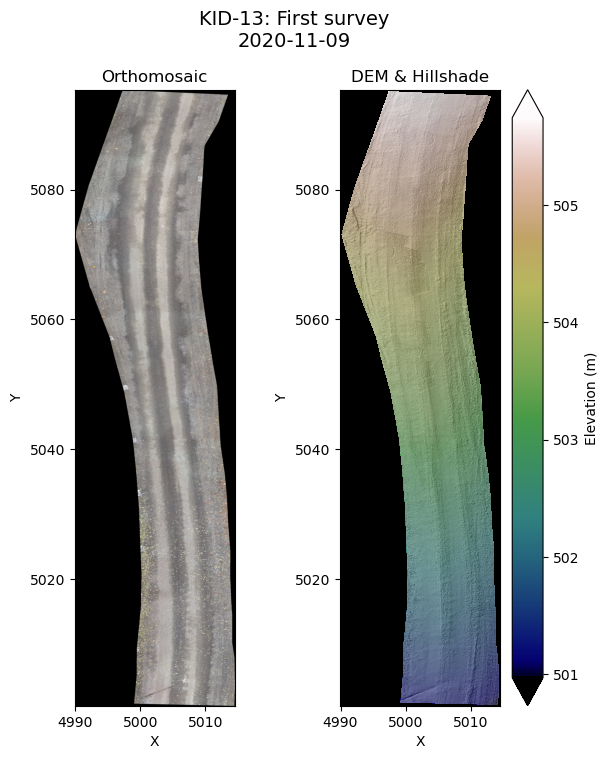

In [17]:
dem_ds = gdal.Open('../data/dems/k13_coreg/KID-13/wsyr1/k13_20201110_sfm_coreg.tif')
dem_ds = gdal.Warp('', dem_ds, cropToCutline=True, cutlineDSName='../data/vectors/kid_mask/roadClip/KID13_roadClip.shp', format='MEM')
#Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
producttype = 'hillshade'
#Create a GDAL hillshade dataset in memory
hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', zFactor=2, format='MEM')
#Read the dataset as a NumPy array
hs = hs_ds.ReadAsArray()
hs_mask = np.ma.masked_values(hs, 0)

fig, ax = plt.subplots(1, 2, figsize=(7, 8))
ds_extent= ds_k13_wsyr1.rio.bounds()
m = ax[1].imshow(ds_k13_wsyr1.isel(time=1)['band1'], cmap = 'gist_earth', extent = ds_extent)
fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax[1], fraction=0.25)

ax[0].imshow(k13_img, extent = ds_extent)
ax[0].set_title('Orthomosaic', fontsize=12)
ax[1].imshow(hs_mask, cmap='gray', extent=ds_extent)
ax[1].imshow(ds_k13_wsyr1.isel(time=1)['band1'], cmap = 'gist_earth', extent = ds_extent, alpha=0.5)
ax[1].set_title('DEM & Hillshade', fontsize=12)
fig.suptitle('KID-13: First survey\n2020-11-09', fontsize=14)
for ax in ax.flat:
    ax.set_facecolor('k')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.show();

In [18]:
reference_dem_k13_dsyr1 = dsm_files_k13_dsyr1[0]

ds_k13_dsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_k13_dsyr1,
    date_times_k13_dsyr1,
    reference_dem_k13_dsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_k13_dsyr1 = ds_k13_dsyr1.rio.clip(k13_mask_gdf["geometry"])

Resampled 4 of 4 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/k13_coreg/KID-13/dsyr1


In [19]:
reference_dem_k13_wsyr2 = dsm_files_k13_wsyr2[0]

ds_k13_wsyr2 = gtsa.io.xr_stack_geotifs(
    dsm_files_k13_wsyr2,
    date_times_k13_wsyr2,
    reference_dem_k13_wsyr2,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_k13_wsyr2 = ds_k13_wsyr2.rio.clip(k13_mask_gdf["geometry"])

Resampled 5 of 5 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/k13_coreg/KID-13/wsyr2


In [20]:
reference_dem_m14_wsyr1 = dsm_files_m14_wsyr1[0]

ds_m14_wsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_m14_wsyr1,
    date_times_m14_wsyr1,
    reference_dem_m14_wsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_m14_wsyr1 = ds_m14_wsyr1.rio.clip(m14_mask_gdf["geometry"])

Resampled 3 of 3 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/wsyr1


In [21]:
m14_ortho = rio.open_rasterio(m14_ortho1).squeeze()
# m14_ortho.rio.write_crs(m14_crs, inplace=True)
m14_ortho_clip = m14_ortho.rio.clip(m14_mask_gdf.geometry)

m14_img = np.dstack((m14_ortho_clip[0], m14_ortho_clip[1], m14_ortho_clip[2]))

/home/adalvis/anaconda3/envs/micro_diff/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


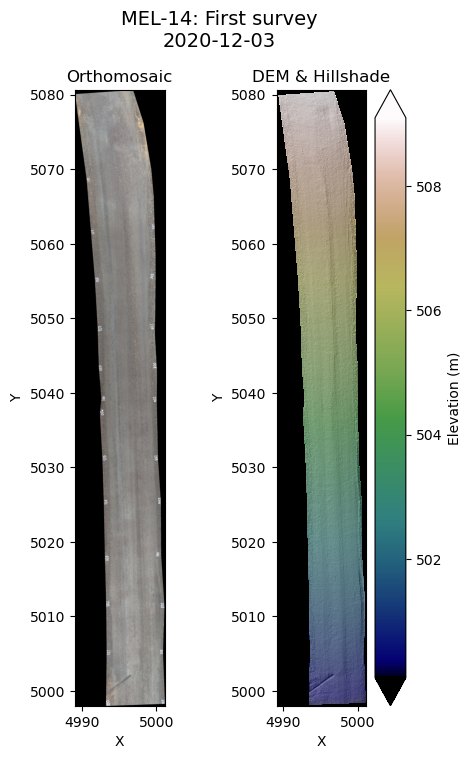

In [22]:
dem_ds = gdal.Open('../data/dems/m14_coreg/MEL-14/wsyr1/m14_20201204_sfm_coreg.tif')
dem_ds = gdal.Warp('', dem_ds, cropToCutline=True, cutlineDSName='../data/vectors/mel_mask/roadClip/MEL14_roadClip.shp', format='MEM')
#Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
producttype = 'hillshade'
#Create a GDAL hillshade dataset in memory
hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', zFactor=2, format='MEM')
#Read the dataset as a NumPy array
hs = hs_ds.ReadAsArray()
hs_mask = np.ma.masked_values(hs, 0)

fig, ax = plt.subplots(1, 2, figsize=(5, 8))
ds_extent= ds_m14_wsyr1.rio.bounds()
m = ax[1].imshow(ds_m14_wsyr1.isel(time=1)['band1'], cmap = 'gist_earth', extent = ds_extent)
plt.colorbar(m,label='Elevation (m)', extend='both', ax=ax[1],fraction=0.25)

ax[0].imshow(m14_img, extent = ds_extent)
ax[0].set_title('Orthomosaic', fontsize=12)
ax[1].imshow(hs_mask, cmap='gray', extent=ds_extent)
ax[1].imshow(ds_m14_wsyr1.isel(time=1)['band1'], cmap = 'gist_earth', extent = ds_extent, alpha=0.5)
ax[1].set_title('DEM & Hillshade', fontsize=12)
fig.suptitle('MEL-14: First survey\n2020-12-03', fontsize=14)
for ax in ax.flat:
    ax.set_facecolor('k')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.show();

In [23]:
reference_dem_m14_dsyr1 = dsm_files_m14_dsyr1[0]

ds_m14_dsyr1 = gtsa.io.xr_stack_geotifs(
    dsm_files_m14_dsyr1,
    date_times_m14_dsyr1,
    reference_dem_m14_dsyr1,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_m14_dsyr1 = ds_m14_dsyr1.rio.clip(m14_mask_gdf["geometry"])

Resampled 3 of 3 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/dsyr1


In [24]:
reference_dem_m14_wsyr2 = dsm_files_m14_wsyr2[0]

ds_m14_wsyr2 = gtsa.io.xr_stack_geotifs(
    dsm_files_m14_wsyr2,
    date_times_m14_wsyr2,
    reference_dem_m14_wsyr2,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

ds_m14_wsyr2 = ds_m14_wsyr2.rio.clip(m14_mask_gdf["geometry"])

Resampled 7 of 7 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems/m14_coreg/MEL-14/wsyr2


## Save rasters for further analysis

In [25]:
# for i in ds_k13_wsyr1.data_vars:
#                 try:
#                     del ds_k13_wsyr1[i].attrs["grid_mapping"]
#                 except:
#                     pass

# ds_k13_wsyr1.isel(time=0).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20201109_lidar_coreg.tif')
# ds_k13_wsyr1.isel(time=1).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20201109_sfm_coreg.tif')
# ds_k13_wsyr1.isel(time=2).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20210208_sfm_coreg.tif')
# ds_k13_wsyr1.isel(time=3).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20210406_sfm_coreg.tif')
# ds_k13_wsyr1.isel(time=4).rio.to_raster('../../ll_micro/k13/wsyr1/k13_20210513_sfm_coreg.tif')

In [ ]:
# for i in ds_k13_dsyr1.data_vars:
#                 try:
#                     del ds_k13_dsyr1[i].attrs["grid_mapping"]
#                 except:
#                     pass

# ds_k13_dsyr1.isel(time=0).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210604_lidar_coreg.tif')
# ds_k13_dsyr1.isel(time=1).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210604_sfm_coreg.tif')
# ds_k13_dsyr1.isel(time=2).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210819_sfm_coreg.tif')
# ds_k13_dsyr1.isel(time=3).rio.to_raster('../../ll_micro/k13/dsyr1/k13_20210913_sfm_coreg.tif')

In [ ]:
# for i in ds_k13_wsyr2.data_vars:
#                 try:
#                     del ds_k13_wsyr2[i].attrs["grid_mapping"]
#                 except:
#                     pass

# ds_k13_wsyr2.isel(time=0).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20211007_lidar_coreg.tif')
# ds_k13_wsyr2.isel(time=1).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20211007_sfm_coreg.tif')
# ds_k13_wsyr2.isel(time=2).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20220208_sfm_coreg.tif')
# ds_k13_wsyr2.isel(time=3).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20220503_sfm_coreg.tif')
# ds_k13_wsyr2.isel(time=4).rio.to_raster('../../ll_micro/k13/wsyr2/k13_20220531_sfm_coreg.tif')

In [ ]:
# for i in ds_m14_wsyr1.data_vars:
#                 try:
#                     del ds_m14_wsyr1[i].attrs["grid_mapping"]
#                 except:
#                     pass

# ds_m14_wsyr1.isel(time=0).rio.to_raster('../../ll_micro/m14/wsyr1/m14_20201203_lidar_coreg.tif')
# ds_m14_wsyr1.isel(time=1).rio.to_raster('../../ll_micro/m14/wsyr1/m14_20201203_sfm_coreg.tif')
# ds_m14_wsyr1.isel(time=2).rio.to_raster('../../ll_micro/m14/wsyr1/m14_20210224_sfm_coreg.tif')

In [ ]:
# for i in ds_m14_dsyr1.data_vars:
#                 try:
#                     del ds_m14_dsyr1[i].attrs["grid_mapping"]
#                 except:
#                     pass

# ds_m14_dsyr1.isel(time=0).rio.to_raster('../../ll_micro/m14/dsyr1/m14_20210603_lidar_coreg.tif')
# ds_m14_dsyr1.isel(time=1).rio.to_raster('../../ll_micro/m14/dsyr1/m14_20210603_sfm_coreg.tif')
# ds_m14_dsyr1.isel(time=2).rio.to_raster('../../ll_micro/m14/dsyr1/m14_20210914_sfm_coreg.tif')

In [ ]:
# for i in ds_m14_wsyr2.data_vars:
#                 try:
#                     del ds_m14_wsyr2[i].attrs["grid_mapping"]
#                 except:
#                     pass

# ds_m14_wsyr2.isel(time=0).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220309_lidar_coreg.tif')
# ds_m14_wsyr2.isel(time=1).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220309_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=2).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220316_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=3).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220324_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=4).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220411_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=5).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220428_sfm_coreg.tif')
# ds_m14_wsyr2.isel(time=6).rio.to_raster('../../ll_micro/m14/wsyr2/m14_20220601_sfm_coreg.tif')

## Compute differences for stack

In [ ]:
# ds_diff_k13_wsyr1_lidar = ds_k13_wsyr1['band1']- ds_k13_wsyr1['band1'].isel(time=0)
ds_diff_k13_wsyr1_sfm = ds_k13_wsyr1['band1']- ds_k13_wsyr1['band1'].isel(time=1)

# ds_diff_k13_dsyr1_lidar = ds_k13_dsyr1['band1']- ds_k13_dsyr1['band1'].isel(time=0)
ds_diff_k13_dsyr1_sfm = ds_k13_dsyr1['band1']- ds_k13_dsyr1['band1'].isel(time=1)

# ds_diff_k13_wsyr2_lidar = ds_k13_wsyr2['band1']- ds_k13_wsyr2['band1'].isel(time=0)
ds_diff_k13_wsyr2_sfm = ds_k13_wsyr2['band1']- ds_k13_wsyr2['band1'].isel(time=1)

# ds_diff_m14_wsyr1_lidar = ds_m14_wsyr1['band1']- ds_m14_wsyr1['band1'].isel(time=0)
ds_diff_m14_wsyr1_sfm = ds_m14_wsyr1['band1']- ds_m14_wsyr1['band1'].isel(time=1)

# ds_diff_m14_dsyr1_lidar = ds_m14_dsyr1['band1']- ds_m14_dsyr1['band1'].isel(time=0)
ds_diff_m14_dsyr1_sfm = ds_m14_dsyr1['band1']- ds_m14_dsyr1['band1'].isel(time=1)

# ds_diff_m14_wsyr2_lidar = ds_m14_wsyr2['band1']- ds_m14_wsyr2['band1'].isel(time=0)
ds_diff_m14_wsyr2_sfm = ds_m14_wsyr2['band1']- ds_m14_wsyr2['band1'].isel(time=1)

In [ ]:
# ds_diff_k13_wsyr1_lidar.isel(time=1).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();
# ds_diff_k13_wsyr1_sfm.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();

# ds_diff_k13_dsyr1_lidar.isel(time=1).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();
# ds_diff_k13_dsyr1_sfm.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();

# ds_diff_k13_wsyr2_lidar.isel(time=1).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();
# ds_diff_k13_wsyr2_sfm.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();

# ds_diff_m14_wsyr1_lidar.isel(time=1).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();
# ds_diff_m14_wsyr1_sfm.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();

# ds_diff_m14_dsyr1_lidar.isel(time=1).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();
# ds_diff_m14_dsyr1_sfm.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();

# ds_diff_m14_wsyr2_lidar.isel(time=1).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();
# ds_diff_m14_wsyr2_sfm.isel(time=0).plot(vmin=-0.05, vmax=0.05, cmap='RdBu')
# plt.show();

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20,9))
ds_extent= ds_diff_m14_wsyr2_sfm.rio.bounds()
m = ax[0].imshow(ds_diff_m14_wsyr2_sfm.isel(time=2), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
fig.colorbar(m, label='Elevation change (m)', extend='both', ax=ax)

ax[0].imshow(ds_diff_m14_wsyr2_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[0].set_title('2022-03-09\nto\n2022-03-16', fontsize=12)
ax[0].set_facecolor('k')

ax[1].imshow(ds_diff_m14_wsyr2_sfm.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[1].set_title('2022-03-09\nto\n2022-03-24', fontsize=12)
ax[1].set_facecolor('k')

ax[2].imshow(ds_diff_m14_wsyr2_sfm.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[2].set_title('2022-03-09\nto\n2022-04-11', fontsize=12)
ax[2].set_facecolor('k')

ax[3].imshow(ds_diff_m14_wsyr2_sfm.isel(time=5), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[3].set_title('2022-03-09\nto\n2022-04-28', fontsize=12)
ax[3].set_facecolor('k')

ax[4].imshow(ds_diff_m14_wsyr2_sfm.isel(time=6), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[4].set_title('2022-03-09\nto\n2022-06-01', fontsize=12)
ax[4].set_facecolor('k')

fig.suptitle('MEL-14: Pre-Gaussian filtering', fontsize=14)
plt.show();

## Apply HPGF to stacked dataset

In [ ]:
sigma = 50
for i in range(0,5):
    # globals()[f'ds_diff_smooth{i}_k13_wsyr1_lidar'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_wsyr1_lidar.isel(time=i).values, sigma = sigma, origmask=True)
    globals()[f'ds_diff_smooth{i}_k13_wsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_wsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

# ds_diff_k13_wsyr1_lidar = ds_diff_k13_wsyr1_lidar - [ds_diff_smooth0_k13_wsyr1_lidar, \
#     ds_diff_smooth1_k13_wsyr1_lidar, ds_diff_smooth2_k13_wsyr1_lidar,\
#     ds_diff_smooth3_k13_wsyr1_lidar, ds_diff_smooth4_k13_wsyr1_lidar]

ds_diff_k13_wsyr1_sfm = ds_diff_k13_wsyr1_sfm - [ds_diff_smooth0_k13_wsyr1_sfm, \
    ds_diff_smooth1_k13_wsyr1_sfm, ds_diff_smooth2_k13_wsyr1_sfm,\
    ds_diff_smooth3_k13_wsyr1_sfm, ds_diff_smooth4_k13_wsyr1_sfm]

In [ ]:
for i in range(0,4):
    # globals()[f'ds_diff_smooth{i}_k13_dsyr1_lidar'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_dsyr1_lidar.isel(time=i).values, sigma = sigma, origmask=True)
    globals()[f'ds_diff_smooth{i}_k13_dsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_dsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

# ds_diff_k13_dsyr1_lidar = ds_diff_k13_dsyr1_lidar - [ds_diff_smooth0_k13_dsyr1_lidar, \
#     ds_diff_smooth1_k13_dsyr1_lidar, ds_diff_smooth2_k13_dsyr1_lidar,\
#     ds_diff_smooth3_k13_dsyr1_lidar]

ds_diff_k13_dsyr1_sfm = ds_diff_k13_dsyr1_sfm - [ds_diff_smooth0_k13_dsyr1_sfm, \
    ds_diff_smooth1_k13_dsyr1_sfm, ds_diff_smooth2_k13_dsyr1_sfm,\
    ds_diff_smooth3_k13_dsyr1_sfm]

In [ ]:
for i in range(0,5):
    # globals()[f'ds_diff_smooth{i}_k13_wsyr2_lidar'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_wsyr2_lidar.isel(time=i).values, sigma = sigma, origmask=True)
    globals()[f'ds_diff_smooth{i}_k13_wsyr2_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_k13_wsyr2_sfm.isel(time=i).values, sigma = sigma, origmask=True)

# ds_diff_k13_wsyr2_lidar = ds_diff_k13_wsyr2_lidar - [ds_diff_smooth0_k13_wsyr2_lidar, \
#     ds_diff_smooth1_k13_wsyr2_lidar, ds_diff_smooth2_k13_wsyr2_lidar,\
#     ds_diff_smooth3_k13_wsyr2_lidar, ds_diff_smooth4_k13_wsyr2_lidar]

ds_diff_k13_wsyr2_sfm = ds_diff_k13_wsyr2_sfm - [ds_diff_smooth0_k13_wsyr2_sfm, \
    ds_diff_smooth1_k13_wsyr2_sfm, ds_diff_smooth2_k13_wsyr2_sfm,\
    ds_diff_smooth3_k13_wsyr2_sfm, ds_diff_smooth4_k13_wsyr2_sfm]

In [ ]:
sigma = 50
for i in range(0,3):
    # globals()[f'ds_diff_smooth{i}_m14_wsyr1_lidar'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_wsyr1_lidar.isel(time=i).values, sigma = sigma, origmask=True)
    globals()[f'ds_diff_smooth{i}_m14_wsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_wsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

# ds_diff_m14_wsyr1_lidar = ds_diff_m14_wsyr1_lidar - [ds_diff_smooth0_m14_wsyr1_lidar, \
#     ds_diff_smooth1_m14_wsyr1_lidar, ds_diff_smooth2_m14_wsyr1_lidar]

ds_diff_m14_wsyr1_sfm = ds_diff_m14_wsyr1_sfm - [ds_diff_smooth0_m14_wsyr1_sfm, \
    ds_diff_smooth1_m14_wsyr1_sfm, ds_diff_smooth2_m14_wsyr1_sfm]

In [ ]:
sigma = 50
for i in range(0,3):
    # globals()[f'ds_diff_smooth{i}_m14_dsyr1_lidar'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_dsyr1_lidar.isel(time=i).values, sigma = sigma, origmask=True)
    globals()[f'ds_diff_smooth{i}_m14_dsyr1_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_dsyr1_sfm.isel(time=i).values, sigma = sigma, origmask=True)

# ds_diff_m14_dsyr1_lidar = ds_diff_m14_dsyr1_lidar - [ds_diff_smooth0_m14_dsyr1_lidar, \
#     ds_diff_smooth1_m14_dsyr1_lidar, ds_diff_smooth2_m14_dsyr1_lidar]

ds_diff_m14_dsyr1_sfm = ds_diff_m14_dsyr1_sfm - [ds_diff_smooth0_m14_dsyr1_sfm, \
    ds_diff_smooth1_m14_dsyr1_sfm, ds_diff_smooth2_m14_dsyr1_sfm]

In [ ]:
sigma = 50
for i in range(0,7):
    # globals()[f'ds_diff_smooth{i}_m14_wsyr2_lidar'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_wsyr2_lidar.isel(time=i).values, sigma = sigma, origmask=True)
    globals()[f'ds_diff_smooth{i}_m14_wsyr2_sfm'], size = micro.hpgf.gauss_fltr_astropy_fft(ds_diff_m14_wsyr2_sfm.isel(time=i).values, sigma = sigma, origmask=True)

# ds_diff_m14_wsyr2_lidar = ds_diff_m14_wsyr2_lidar - [ds_diff_smooth0_m14_wsyr2_lidar, \
#     ds_diff_smooth1_m14_wsyr2_lidar, ds_diff_smooth2_m14_wsyr2_lidar,\
#     ds_diff_smooth3_m14_wsyr2_lidar, ds_diff_smooth4_m14_wsyr2_lidar,\
#     ds_diff_smooth5_m14_wsyr2_lidar, ds_diff_smooth6_m14_wsyr2_lidar]

ds_diff_m14_wsyr2_sfm = ds_diff_m14_wsyr2_sfm - [ds_diff_smooth0_m14_wsyr2_sfm, \
    ds_diff_smooth1_m14_wsyr2_sfm, ds_diff_smooth2_m14_wsyr2_sfm,\
    ds_diff_smooth3_m14_wsyr2_sfm, ds_diff_smooth4_m14_wsyr2_sfm,\
    ds_diff_smooth5_m14_wsyr2_sfm, ds_diff_smooth6_m14_wsyr2_sfm]

## Plot difference maps

In [ ]:
# fig, ax = plt.subplots(1, 4, figsize=(15,9))
# ds_extent= ds_diff_k13_wsyr1_lidar.rio.bounds()
# m = ax[0].imshow(ds_diff_k13_wsyr1_lidar.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_k13_wsyr1_lidar.isel(time=1), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('KID-13\n2020-11-09 LiDAR\n2020-11-09 SfM')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_k13_wsyr1_lidar.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('KID-13\n2020-11-09 LiDAR\n2021-02-08 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_k13_wsyr1_lidar.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('KID-13\n2020-11-09 LiDAR\n2021-04-06 SfM')
# ax[2].set_facecolor('k')

# ax[3].imshow(ds_diff_k13_wsyr1_lidar.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[3].set_title('KID-13\n2020-11-09 LiDAR\n2021-05-13 SfM')
# ax[3].set_facecolor('k')
# plt.show();


# fig, ax = plt.subplots(1, 4, figsize=(15,9))
# ds_extent= ds_diff_k13_wsyr1_sfm.rio.bounds()
# m = ax[0].imshow(ds_diff_k13_wsyr1_sfm.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_k13_wsyr1_sfm.isel(time=0), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('KID-13\n2020-11-09 SfM\n2020-11-09 LiDAR')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_k13_wsyr1_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('KID-13\n2020-11-09 SfM\n2021-02-08 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_k13_wsyr1_sfm.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('KID-13\n2020-11-09 SfM\n2021-04-06 SfM')
# ax[2].set_facecolor('k')

# ax[3].imshow(ds_diff_k13_wsyr1_sfm.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[3].set_title('KID-13\n2020-11-09 SfM\n2021-05-13 SfM')
# ax[3].set_facecolor('k')
# plt.show();

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(13,9))
# ds_extent= ds_diff_k13_dsyr1_lidar.rio.bounds()
# m = ax[0].imshow(ds_diff_k13_dsyr1_lidar.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_k13_dsyr1_lidar.isel(time=1), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('KID-13\n2021-06-04 LiDAR\n2021-06-04 SfM')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_k13_dsyr1_lidar.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('KID-13\n2021-06-04 LiDAR\n2021-08-19 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_k13_dsyr1_lidar.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('KID-13\n2021-06-04 LiDAR\n2021-09-13 SfM')
# ax[2].set_facecolor('k')
# plt.show();


# fig, ax = plt.subplots(1, 3, figsize=(13,9))
# ds_extent= ds_diff_k13_dsyr1_sfm.rio.bounds()
# m = ax[0].imshow(ds_diff_k13_dsyr1_sfm.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_k13_dsyr1_sfm.isel(time=0), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('KID-13\n2021-06-04 SfM\n2021-06-04 LiDAR')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_k13_dsyr1_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('KID-13\n2021-06-04 SfM\n2021-08-19 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_k13_dsyr1_sfm.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('KID-13\n2021-06-04 SfM\n2021-09-13 SfM')
# ax[2].set_facecolor('k')
# plt.show();

In [ ]:
# fig, ax = plt.subplots(1, 4, figsize=(15,9))
# ds_extent= ds_diff_k13_wsyr2_lidar.rio.bounds()
# m = ax[0].imshow(ds_diff_k13_wsyr2_lidar.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_k13_wsyr2_lidar.isel(time=1), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('KID-13\n2021-10-07 LiDAR\n2021-10-07 SfM')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_k13_wsyr2_lidar.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('KID-13\n2021-10-07 LiDAR\n2022-02-08 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_k13_wsyr2_lidar.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('KID-13\n2021-10-07 LiDAR\n2022-05-03 SfM')
# ax[2].set_facecolor('k')

# ax[3].imshow(ds_diff_k13_wsyr2_lidar.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[3].set_title('KID-13\n2021-10-07 LiDAR\n2022-05-31 SfM')
# ax[3].set_facecolor('k')
# plt.show();


# fig, ax = plt.subplots(1, 4, figsize=(15,9))
# ds_extent= ds_diff_k13_wsyr2_sfm.rio.bounds()
# m = ax[0].imshow(ds_diff_k13_wsyr2_sfm.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_k13_wsyr2_sfm.isel(time=0), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('KID-13\n2021-10-07 SfM\n2021-10-07 LiDAR')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_k13_wsyr2_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('KID-13\n2021-10-07 SfM\n2022-02-08 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_k13_wsyr2_sfm.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('KID-13\n2021-10-07 SfM\n2022-05-03 SfM')
# ax[2].set_facecolor('k')

# ax[3].imshow(ds_diff_k13_wsyr2_sfm.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[3].set_title('KID-13\n2021-10-07 SfM\n2022-05-31 SfM')
# ax[3].set_facecolor('k')
# plt.show();

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(7,9))
# ds_extent= ds_diff_m14_wsyr1_lidar.rio.bounds()
# m = ax[0].imshow(ds_diff_m14_wsyr1_lidar.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_m14_wsyr1_lidar.isel(time=1), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('MEL-14\n2020-12-03 LiDAR\n2020-12-03 SfM')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_m14_wsyr1_lidar.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('MEL-14\n2020-12-03 LiDAR\n2021-02-24 SfM')
# ax[1].set_facecolor('k')
# plt.show();


# fig, ax = plt.subplots(1, 2, figsize=(7,9))
# ds_extent= ds_diff_m14_wsyr1_sfm.rio.bounds()
# m = ax[0].imshow(ds_diff_m14_wsyr1_sfm.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_m14_wsyr1_sfm.isel(time=0), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('MEL-14\n2020-12-03 SfM\n2020-12-03 LiDAR')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_m14_wsyr1_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('MEL-14\n2020-12-03 SfM\n2021-02-24 SfM')
# ax[1].set_facecolor('k')
# plt.show();

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(7,9))
# ds_extent= ds_diff_m14_dsyr1_lidar.rio.bounds()
# m = ax[0].imshow(ds_diff_m14_dsyr1_lidar.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_m14_dsyr1_lidar.isel(time=1), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('MEL-14\n2021-06-03 LiDAR\n2021-06-03 SfM')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_m14_dsyr1_lidar.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('MEL-14\n2021-06-03 LiDAR\n2021-09-14 SfM')
# ax[1].set_facecolor('k')
# plt.show();


# fig, ax = plt.subplots(1, 2, figsize=(7,9))
# ds_extent= ds_diff_m14_dsyr1_sfm.rio.bounds()
# m = ax[0].imshow(ds_diff_m14_dsyr1_sfm.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_m14_dsyr1_sfm.isel(time=0), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('MEL-14\n2021-06-03 SfM\n2021-06-03 LiDAR')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_m14_dsyr1_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('MEL-14\n2021-06-03 SfM\n2021-09-14 SfM')
# ax[1].set_facecolor('k')
# plt.show();

In [ ]:
# fig, ax = plt.subplots(1, 6, figsize=(20,9))
# ds_extent= ds_diff_m14_wsyr2_lidar.rio.bounds()
# m = ax[0].imshow(ds_diff_m14_wsyr2_lidar.isel(time=0), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
# fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)

# ax[0].imshow(ds_diff_m14_wsyr2_lidar.isel(time=1), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[0].set_title('MEL-14\n2022-03-09 LiDAR\n2022-03-09 SfM')
# ax[0].set_facecolor('k')

# ax[1].imshow(ds_diff_m14_wsyr2_lidar.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[1].set_title('MEL-14\n2022-03-09 LiDAR\n2022-03-16 SfM')
# ax[1].set_facecolor('k')

# ax[2].imshow(ds_diff_m14_wsyr2_lidar.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[2].set_title('MEL-14\n2022-03-09 LiDAR\n2022-03-24 SfM')
# ax[2].set_facecolor('k')

# ax[3].imshow(ds_diff_m14_wsyr2_lidar.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[3].set_title('MEL-14\n2022-03-09 LiDAR\n2022-04-11 SfM')
# ax[3].set_facecolor('k')

# ax[4].imshow(ds_diff_m14_wsyr2_lidar.isel(time=5), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[4].set_title('MEL-14\n2022-03-09 SfM\n2022-04-28 SfM')
# ax[4].set_facecolor('k')

# ax[5].imshow(ds_diff_m14_wsyr2_lidar.isel(time=6), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
# ax[5].set_title('MEL-14\n2022-03-09 SfM\n2022-06-01 SfM')
# ax[5].set_facecolor('k')
# plt.show();


fig, ax = plt.subplots(1, 5, figsize=(20,9))
ds_extent= ds_diff_m14_wsyr2_sfm.rio.bounds()
m = ax[0].imshow(ds_diff_m14_wsyr2_sfm.isel(time=2), cmap = 'RdBu', vmin=-0.025, vmax=0.025)
fig.colorbar(m, label='Elevation change (m)', extend='both', ax=ax)

ax[0].imshow(ds_diff_m14_wsyr2_sfm.isel(time=2), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[0].set_title('2022-03-09\nto\n2022-03-16', fontsize=12)
ax[0].set_facecolor('k')

ax[1].imshow(ds_diff_m14_wsyr2_sfm.isel(time=3), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[1].set_title('2022-03-09\nto\n2022-03-24', fontsize=12)
ax[1].set_facecolor('k')

ax[2].imshow(ds_diff_m14_wsyr2_sfm.isel(time=4), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[2].set_title('2022-03-09\nto\n2022-04-11', fontsize=12)
ax[2].set_facecolor('k')

ax[3].imshow(ds_diff_m14_wsyr2_sfm.isel(time=5), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[3].set_title('2022-03-09\nto\n2022-04-28', fontsize=12)
ax[3].set_facecolor('k')

ax[4].imshow(ds_diff_m14_wsyr2_sfm.isel(time=6), cmap='RdBu', vmin=-0.025, vmax=0.025, extent = ds_extent)
ax[4].set_title('2022-03-09\nto\n2022-06-01', fontsize=12)
ax[4].set_facecolor('k')

fig.suptitle('MEL-14: Post-Gaussian filtering', fontsize=14)
plt.show();

## Raster stats

In [ ]:
# ds_diff_k13_wsyr1_lidar.to_netcdf('../data/k13_wsyr1_diff.nc')
# ds_diff_k13_dsyr1_lidar.to_netcdf('../data/k13_dsyr1_diff.nc')
# ds_diff_k13_wsyr2_lidar.to_netcdf('../data/k13_wsyr2_diff.nc')

In [ ]:
ds_diff_k13_wsyr1_sfm.to_netcdf('../data/k13_wsyr1_diff_sfm.nc')
ds_diff_k13_dsyr1_sfm.to_netcdf('../data/k13_dsyr1_diff_sfm.nc')
ds_diff_k13_wsyr2_sfm.to_netcdf('../data/k13_wsyr2_diff_sfm.nc')

In [ ]:
# ds_diff_m14_wsyr1_lidar.to_netcdf('../data/m14_wsyr1_diff.nc')
# ds_diff_m14_dsyr1_lidar.to_netcdf('../data/m14_dsyr1_diff.nc')
# ds_diff_m14_wsyr2_lidar.to_netcdf('../data/m14_wsyr2_diff.nc')

In [ ]:
ds_diff_m14_wsyr1_sfm.to_netcdf('../data/m14_wsyr1_diff_sfm.nc')
ds_diff_m14_dsyr1_sfm.to_netcdf('../data/m14_dsyr1_diff_sfm.nc')
ds_diff_m14_wsyr2_sfm.to_netcdf('../data/m14_wsyr2_diff_sfm.nc')

In [ ]:
# pprint(rasterstats.zonal_stats(k13_mask_gdf, 'k13_wsyr1_diff.tif', \
#     stats=['min', 'max', 'median', 'mean', 'std', 'sum']))
# pprint(rasterstats.zonal_stats(k13_mask_gdf, 'k13_dsyr1_diff.tif', \
#     stats=['min', 'max', 'median', 'mean', 'std', 'sum']))
# pprint(rasterstats.zonal_stats(k13_mask_gdf, 'k13_wsyr2_diff.tif', \
#     stats=['min', 'max', 'median', 'mean', 'std', 'sum']))
# pprint(rasterstats.zonal_stats(m14_mask_gdf, 'm14_wsyr1_diff.tif', \
#     stats=['min', 'max', 'median', 'mean', 'std', 'sum']))
# pprint(rasterstats.zonal_stats(m14_mask_gdf, 'm14_dsyr1_diff.tif', \
#     stats=['min', 'max', 'median', 'mean', 'std', 'sum']))
# pprint(rasterstats.zonal_stats(m14_mask_gdf, 'm14_wsyr2_diff.tif', \
#     stats=['min', 'max', 'median', 'mean', 'std', 'sum']))
